**Problem statement**

You own the mall and want to understand the customers like who can be easily converge [Target Customers] so that the sense can be given to marketing team and plan the strategy accordingly.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


**import the required libraries**

In [2]:
import numpy as np
import pandas as pd
import missingno
from collections import Counter

### Data Visualization

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from tabulate import tabulate

### Remove unnecessary warnings

import warnings
warnings.filterwarnings('ignore')


**Load the dataset**

In [3]:
data = pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")

In [4]:
data.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
data.shape

(200, 5)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
### Changing the datatype of the column - Gender to category

data.Gender = data.Gender.astype('category')

In [8]:
# Renaming columns.
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(' ','_')

In [9]:
data.dtypes

CustomerID                   int64
Gender                    category
Age                          int64
Annual_Income_(k$)           int64
Spending_Score_(1-100)       int64
dtype: object

In [10]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual_Income_(k$)        0
Spending_Score_(1-100)    0
dtype: int64

In [11]:
data.nunique()

CustomerID                200
Gender                      2
Age                        51
Annual_Income_(k$)         64
Spending_Score_(1-100)     84
dtype: int64

In [12]:
data['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

<Axes: xlabel='Gender', ylabel='count'>

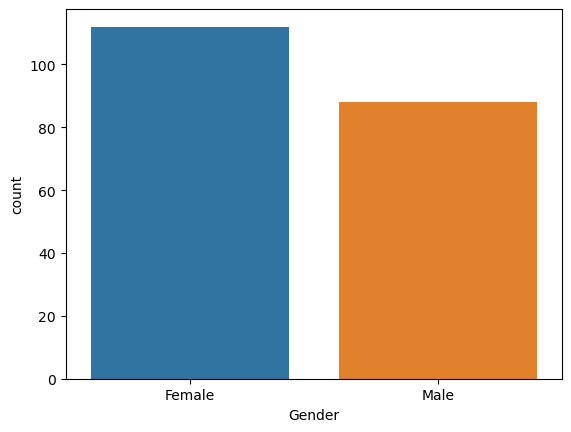

In [13]:
# Observing target variable counts through bargraph:
sns.countplot(x='Gender',data=data)

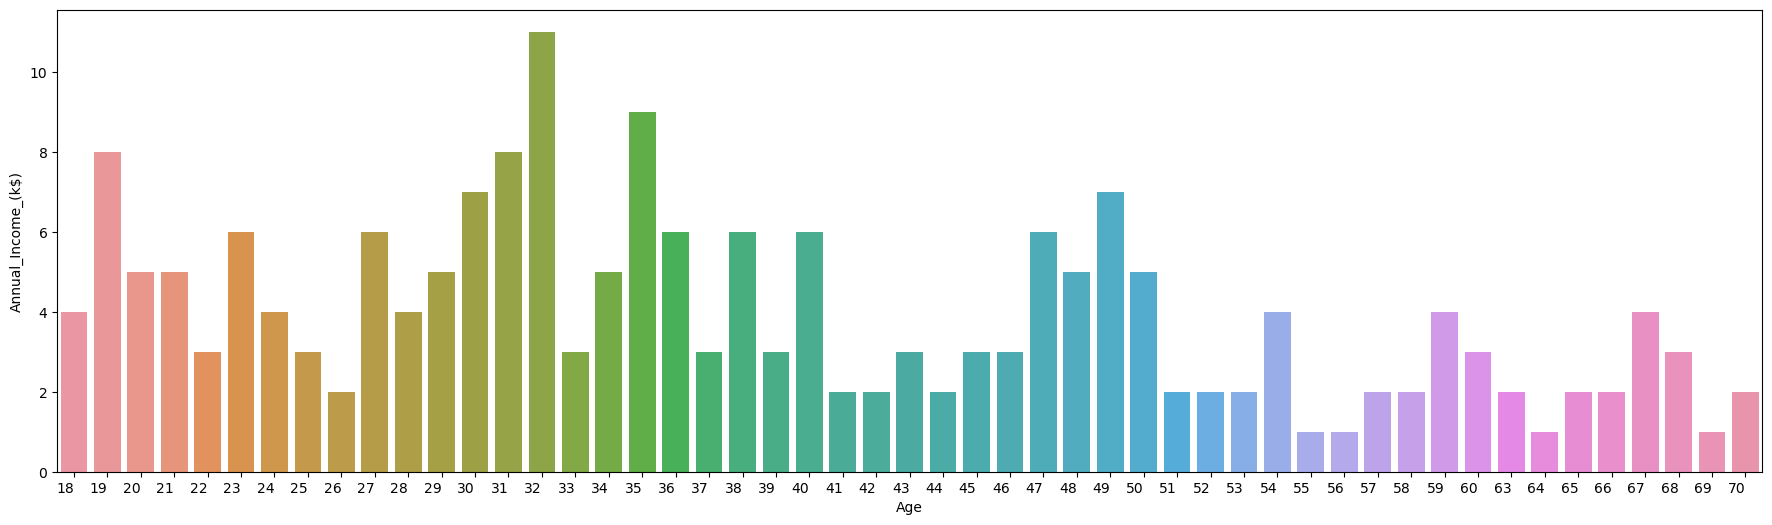

In [14]:
#checking the whitch age reported more fraud:
df=data.groupby('Age').agg({'Annual_Income_(k$)':'count'}).reset_index()

fig, (ax1) = plt.subplots(1,1,figsize=(22, 6))
graph =sns.barplot(x='Age', y='Annual_Income_(k$)', data = df, ax=ax1)

graph.set_xticklabels(graph.get_xticklabels(),
                    rotation=0,
                    horizontalalignment='right'
                    );

from above visualisation we can know that age 32 are getting more annual_income

<Axes: xlabel='Gender', ylabel='Spending_Score_(1-100)'>

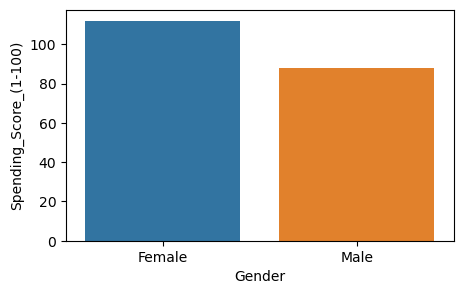

In [15]:
prdata=data.groupby('Gender').agg({'Spending_Score_(1-100)':'count'}).reset_index()
fig, (ax1) = plt.subplots(1,1,figsize=(5, 3))
sns.barplot(x='Gender', y='Spending_Score_(1-100)', data = prdata, ax=ax1)

<Axes: xlabel='Age', ylabel='Annual_Income_(k$)'>

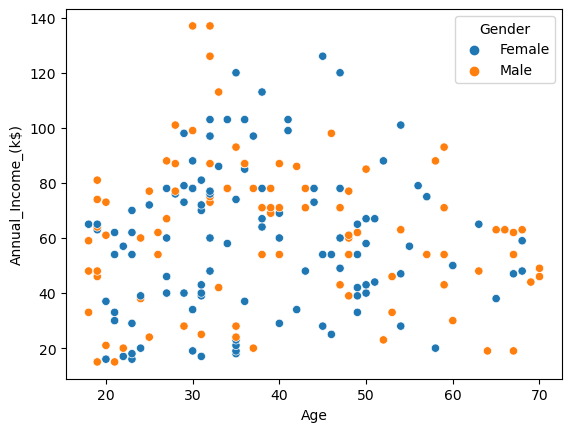

In [16]:
### Scatterplot between Age and Annual Income

sns.scatterplot(data = data, x = "Age", y = "Annual_Income_(k$)", hue = "Gender")

<Axes: xlabel='Age', ylabel='Spending_Score_(1-100)'>

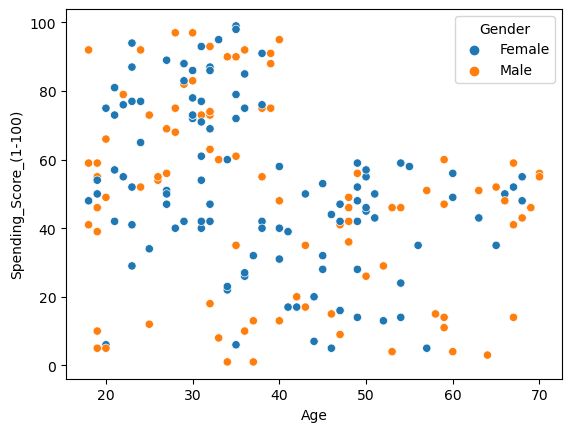

In [17]:
### Scatterplot between Age and Spending Score (1-100)

sns.scatterplot(data = data, x = "Age", y = "Spending_Score_(1-100)", hue = "Gender")

From the above graph, we can see that there is no significant relationship between Age and Annual Income (k$)

In [18]:
# ### Dropping the columns - CustomerId from the dataset

# dataset.drop(['CustomerID'], axis = 1, inplace = True)
# dataset

In [19]:
# For our model, we can choose whatever variables we think are relevant or necessary, we needn't choose all.
# I'm going to choose age, annual income and spending score columns for my clustering model.
X = data.iloc[:,[2,3,4]].values


Now, we need to find the optimal number of clusters for this dataset. To do that, we will use WCSS (within-cluster-sum-of-squares) parameter. WCSS is the sum of squares of the distances of each data point in all clusters to their respective centroids. The idea is to minimise the sum.

In [20]:
# It will find wcss value for different number of clusters (for 1 cluster, for 2...until 10 clusters) and put it in our list

In [21]:
wcss = []
for i in range(1,11): 
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=50)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
wcss

[308812.78,
 212840.1698209719,
 143342.751571706,
 104366.15145556198,
 75350.77917248776,
 58300.44332159069,
 51118.949931647294,
 44637.39564017064,
 40936.763713763714,
 37048.59133348133]

As we can see, 10 clusters have minimum wcss but we need to check elbow points (later explained) so let's still visualize it.

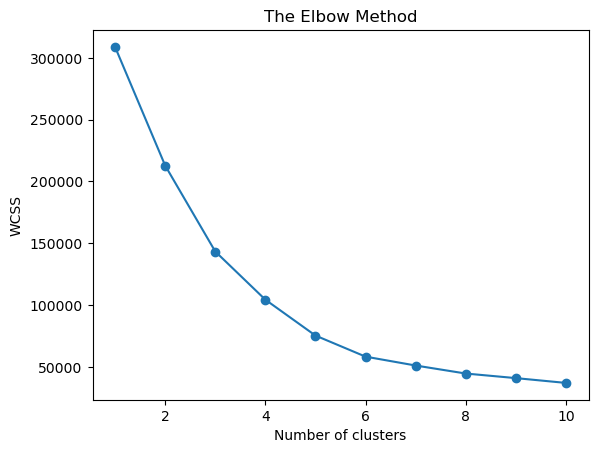

In [22]:
plt.plot(range(1, 11), wcss, marker = 'o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

These are the elbow points. there is no more significant change in value so 5 is the most suitable number of clusters.

# Model_Building

# K Means_Clustering

In [23]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++',random_state = 0)

In [24]:
# we need a label for each datapoint relative to their clusters (will be split into 5 clusters and each will be labelled 0-4)
y = kmeans.fit_predict(X)

In [25]:
# Creating a New Dataframe with an appended cluster column

df_Kmeans = data.copy()            ## making a copy of original dataframe
df_Kmeans['Cluster'] = y  ## appending the cluster column
print(df_Kmeans.head(5))

   CustomerID  Gender  Age  Annual_Income_(k$)  Spending_Score_(1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Cluster  
0        0  
1        4  
2        0  
3        4  
4        0  


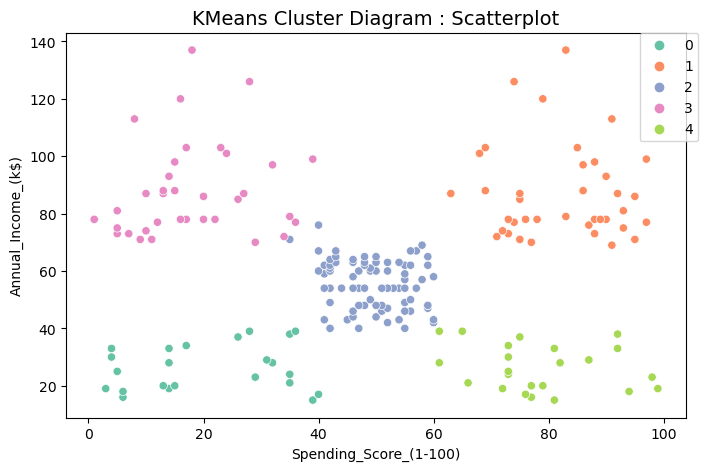

In [26]:
## Visualising the new dataframe with cluster numbers through scatterplot

plt.figure(figsize=(8,5))
plt.title('KMeans Cluster Diagram : Scatterplot', fontsize=14)
sns.scatterplot(data=df_Kmeans, x='Spending_Score_(1-100)', y='Annual_Income_(k$)', hue='Cluster', palette="Set2")
plt.legend(bbox_to_anchor=(1.02, 1), loc='best', borderaxespad=0)
plt.show()

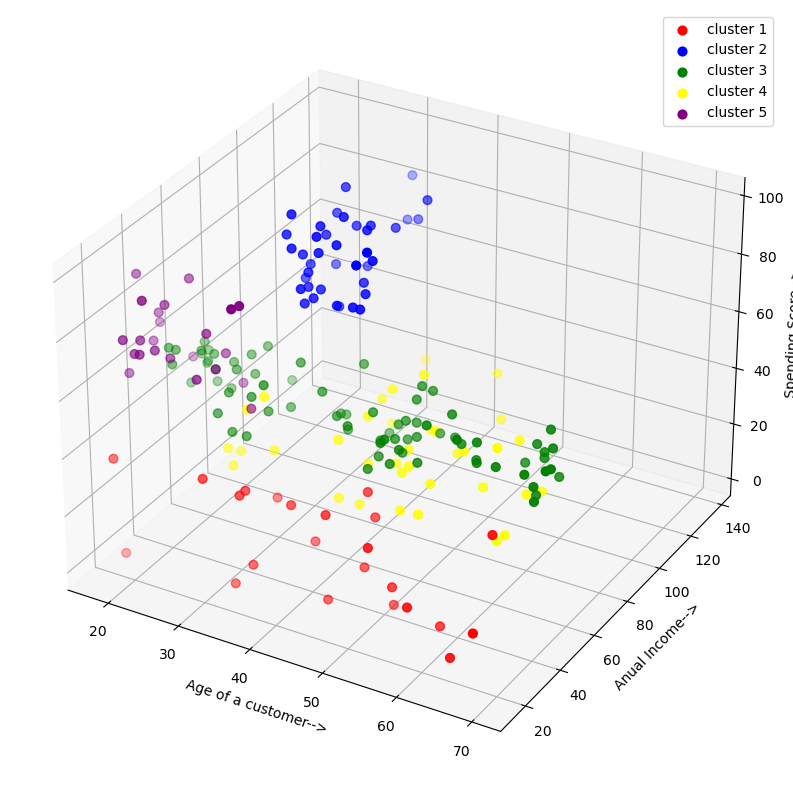

In [27]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[y == 0,0],X[y == 0,1],X[y == 0,2], s = 40 , color = 'red', label = "cluster 1")
ax.scatter(X[y == 1,0],X[y == 1,1],X[y == 1,2], s = 40 , color = 'blue', label = "cluster 2")
ax.scatter(X[y == 2,0],X[y == 2,1],X[y == 2,2], s = 40 , color = 'green', label = "cluster 3")
ax.scatter(X[y == 3,0],X[y == 3,1],X[y == 3,2], s = 40 , color = 'yellow', label = "cluster 4")
ax.scatter(X[y == 4,0],X[y == 4,1],X[y == 4,2], s = 40 , color = 'purple', label = "cluster 5")
ax.set_xlabel('Age of a customer-->')
ax.set_ylabel('Anual Income-->')
ax.set_zlabel('Spending Score-->')
ax.legend()
plt.show()

As we can see, clusters 3 and 5 have higher spending scores.

Cluster 3 are people aged less than 30 with very high annual incomes, them having a high spending score makes sense. So, to keep this going on, these people could be given better offers to attract them.

Cluster 5 are also people aged less than 30 but with low incomes. As this group of people do like to shop, they can be offered discounts and buy get more free offers to attract them more.

# Hierarchial Clustering

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [29]:
data.head(3)

,CustomerID,Gender,Age,Annual_Income_(k$),Spending_Score_(1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


In [30]:
## Let's start analysis by creating a subset dataframe

x = data[['Annual_Income_(k$)', 'Spending_Score_(1-100)']].copy()
print(x.head(5))

   Annual_Income_(k$)  Spending_Score_(1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40


In [31]:
## Let's start the Hierarchial analysis by normalizing the data and 
## building a dataframe for analysis

norm = MinMaxScaler()

X_Hierar = norm.fit_transform(x)
X_Hierar = pd.DataFrame(X_Hierar, columns=x.columns)
print(X_Hierar.head(5))

   Annual_Income_(k$)  Spending_Score_(1-100)
0            0.000000                0.387755
1            0.000000                0.816327
2            0.008197                0.051020
3            0.008197                0.775510
4            0.016393                0.397959


In [32]:
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

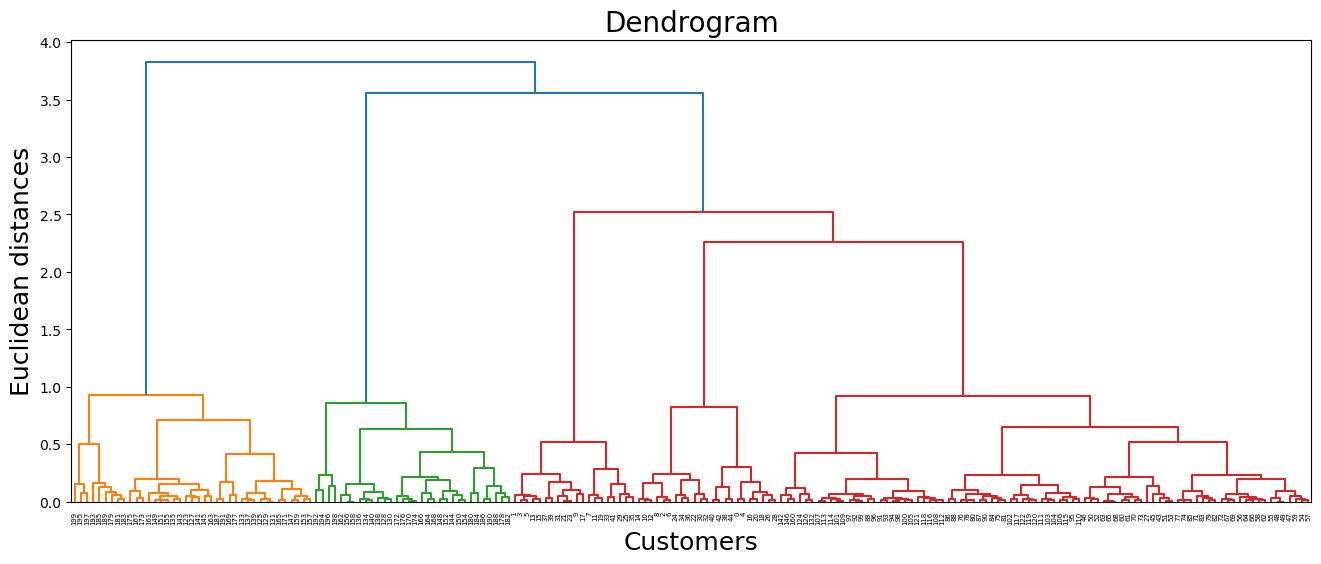

In [33]:
## Build dendrogram to find out the optimal number of clusters

plt.figure(figsize=(16,6))
dendrogram = shc.dendrogram(shc.linkage(X_Hierar, method = 'ward'))
plt.title('Dendrogram', fontsize=20)
plt.xlabel('Customers', fontsize=18)
plt.ylabel('Euclidean distances', fontsize=18)
plt.show()

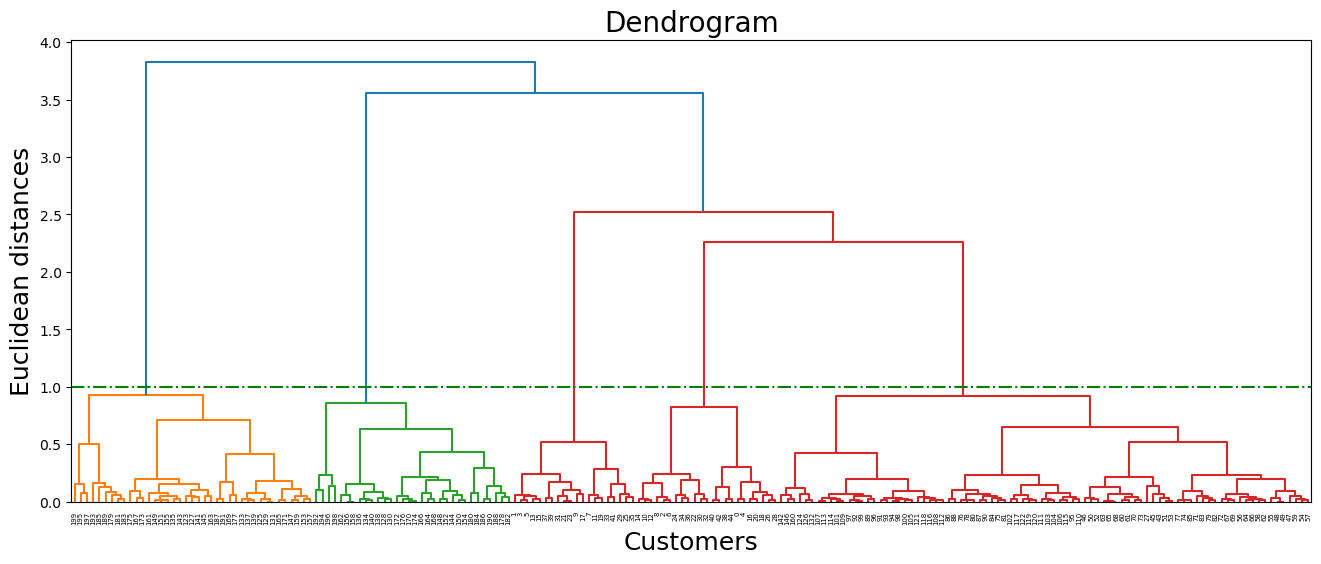

In [34]:
## Draw the threshold level to identify the ideal number of clusters

plt.figure(figsize=(16,6))
dendrogram = shc.dendrogram(shc.linkage(X_Hierar, method = 'ward'))
plt.axhline(y = 1, color = 'g', linestyle = 'dashdot')

plt.title('Dendrogram', fontsize=20)
plt.xlabel('Customers', fontsize=18)
plt.ylabel('Euclidean distances', fontsize=18)
plt.show()

Find the longest vertical line that is not intersected by any line horizontally. Draw a threshold from there. The number of lines crossed by the boundary gives the number of clusters.
so here The threshold line intersects 5 vertical lines, hence we can conclude that the number of clusters we can have as 5.

In [35]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')

In [36]:
List =[]
for k in range(1,11):
    hc = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'ward') # ** eopn dictionary
    hc.fit(X_Hierar)
    List.append(hc)

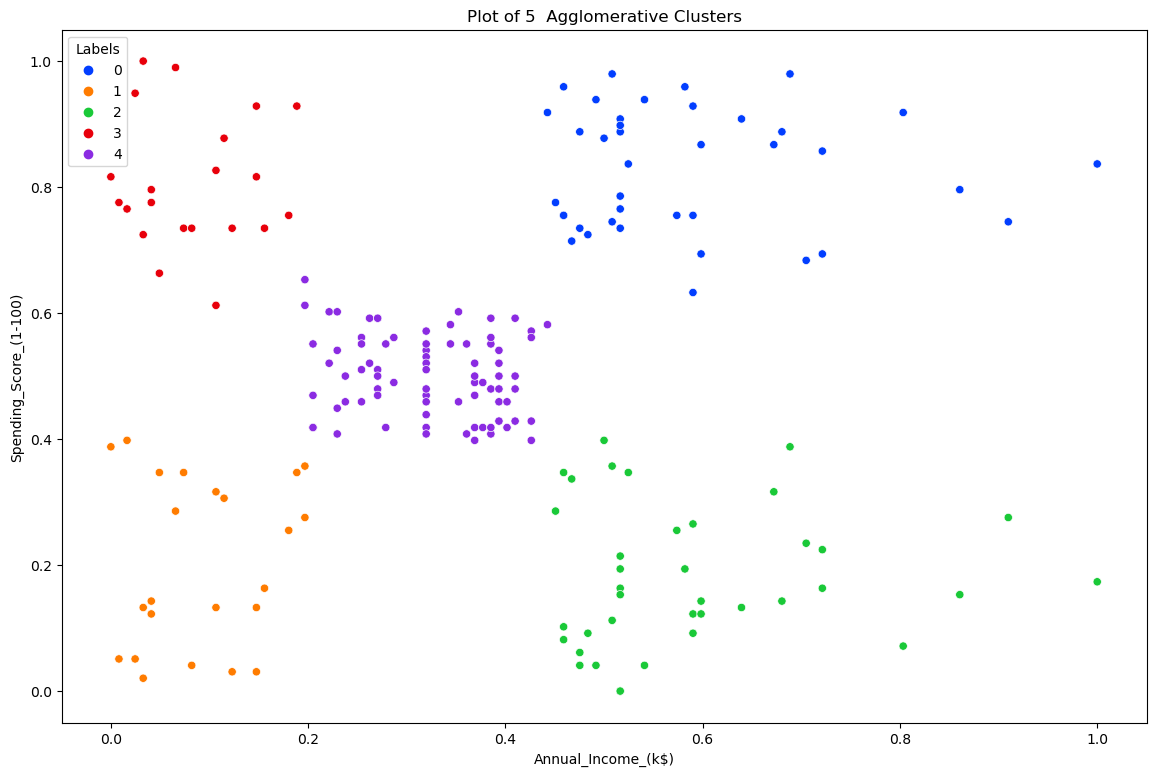

In [37]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix

agglomerative_clusters = AgglomerativeClustering(n_clusters=5, linkage='average').fit(X_Hierar)

X_Hierar['Labels'] = agglomerative_clusters.labels_
plt.figure(figsize=(14, 9))
sns.scatterplot(data=X_Hierar,x=X_Hierar['Annual_Income_(k$)'],y= X_Hierar['Spending_Score_(1-100)'], hue=X_Hierar['Labels'], palette=sns.color_palette('bright', 5))
plt.title('Plot of 5  Agglomerative Clusters')
plt.show()

Cluster with Label 0 displays Those who have high annual income but low spending score
Cluster with Label 1 displays Those who have mid-level annual income and mid-level spending score
Cluster with Label 2 displays Those who have high annual income and high spending score
Cluster with Label 3 displays Those who have low annual income but high spending score
Cluster with Label 4 displays Those who have low annual income and low spending score